# Example: Analysis of Covered Call Positions on AMD
In this example, we analyze a covered call position on Advanced Micro Devices, Inc. (AMD) using historical options data. A covered call is a two-leg strategy in which equity is purchased and call contracts are sold on a share-for-share basis against those shares.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Construct profit diagrams for covered call positions:__ Build profit and loss profiles for covered calls by combining long equity with short call contracts, and compute the breakeven point, maximum profit, and maximum loss scenarios.
> * __Calculate probabilities for covered call outcomes:__ Use cumulative distribution functions of projected share price distributions to determine the likelihood of downside loss, maximum profit, and opportunity loss scenarios at expiration.
> * __Evaluate opportunity risk in covered calls:__ Compare the capped profit potential of the covered call to the unlimited upside of holding shares alone, and quantify the probability of missing gains above the strike price.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the metadata in the `metadata::Dict{String,Any}` variable and the options chain data in the `optionschain::DataFrame` variable.

In [2]:
metadata, optionschain, ticker = let
    
    # initialize -
    ticker = "amd";
    options_dataset = MyOptionsChainDataSet(ticker = ticker);
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain, ticker) # return
end;

What's in the `metadata::Dict{String,Any}` dictionary? 

In [3]:
let

    # initialize -
    df = DataFrame();
    fields = metadata |> keys |> collect |> sort;

    for i ∈ eachindex(fields)
        field = fields[i];
        row_df = (
            field = field |> String,
            value = metadata[field] |> string,
        );
        push!(df, row_df);
    end

    # make a table -
    pretty_table(
         df;
         fit_table_in_display_horizontally = false,
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );

end

 ---------------------------- --------------
                       field          value 
                      String         String 
 ---------------------------- --------------
                         DTE             58
                      atm_IV         0.5903
             expiration_date     2025-12-19
       historical_volatility         0.7971
                   is_weekly          false
               purchase_date     2025-10-22
                      source   barchart.com
  underlying_share_price_ask         225.91
  underlying_share_price_bid         225.74
  underlying_share_price_mid         225.78
 ---------------------------- --------------


What about the `optionschain::DataFrame` variable?

In [4]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


In [5]:
let
        
        # initialize -
        δ = 0.5; # set the delta for ATM search
        options_chain = optionschain;
        Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

        # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
        atm_call_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, options_chain);
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,115.0,0.4972,114.4,114.98,115.55,121.33,0,"3,187",0.8688,0.9853,Call
2,120.0,0.4754,109.65,110.1,110.55,109.75,1,"5,468",0.7294,0.9915,Call
3,125.0,0.4535,104.65,105.2,105.75,105.85,10,"5,090",0.8135,0.9796,Call
4,130.0,0.4317,99.9,100.35,100.8,98.6,2,"3,540",0.7909,0.9756,Call
5,135.0,0.4098,95.25,95.65,96.05,96.69,4,"3,604",0.7897,0.9681,Call
6,140.0,0.388,90.25,90.7,91.15,92.35,46,"4,005",0.7459,0.9658,Call
7,145.0,0.3661,85.45,85.93,86.4,85.15,33,"2,295",0.7261,0.9593,Call
8,150.0,0.3442,80.75,81.23,81.7,79.6,92,"6,619",0.7115,0.9508,Call
9,155.0,0.3224,76.2,76.55,76.9,77.8,3,"4,606",0.6951,0.9415,Call


### Constants
Let's set a value for the step size `Δt::Float64`, i.e., `1 day` in units of years (assuming a `365-day` year), and the risk-free rate at the time we gathered the data for the option contracts; we approximate this value using the [yield on the 10-year Treasury Note](https://ycharts.com/indicators/10_year_treasury_rate). We also set a value for the underlying share price `Sₒ::Float64`, the number of levels in the binomial tree model `h::Int64`, the strike price `K::Float64`, and the direction parameter `θ::Int64`; we assume 6 levels per day.

In [6]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x); # mid underlying price on purchase date, 10-22-2025

Other constants:

In [7]:
Δt = (1/365); # options use 365 day year
DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 8*DTE |> x-> floor(Int, x); # 8-points per day
w = 0.3; # width parameter
θ = -1; # long/short indicator: -1 = short, +1 = long

___

## Task 1: Select a random call option from the dataset
In this task, we'll select call option contracts such that $S_{\circ}<K\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$, and we purchase the counter asset, in this case shares, from the market at $S_{\circ}$. Let's begin by filtering the contracts in the `dataset::DataFrame` to include only `call` contracts that obey the strike price constraint.

> __Assumption:__ We assume that we are purchasing shares at the current underlying share price `Sₒ::Float64` from the market, and then immediately selling call contracts with strike prices `K::Float64` that are out-of-the-money (OTM), i.e., $S_{\circ}<K\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$ is a small width parameter. If we already owned the shares, say at $S^{\dagger} \leq S_{\circ}$, then the analysis would be slightly different since our cost basis would be $S^{\dagger}$ instead of $S_{\circ}$.

Save the filtered selection of `call` contracts in the `call_contracts::DataFrame` variable:

In [8]:
call_contracts = filter(:Type=>x->x == "Call", optionschain) |> y -> filter(:Strike=> x-> (x > Sₒ && x ≤ (1+w)*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,230.0,-0.0055,21.5,21.58,21.65,21.4,632,"8,311",0.5912,0.5488,Call
2,240.0,-0.0492,17.3,17.35,17.4,17.41,473,"8,889",0.5896,0.4766,Call
3,250.0,-0.0929,13.75,13.83,13.9,13.75,"3,670","9,091",0.5866,0.4072,Call
4,260.0,-0.1367,10.9,10.98,11.05,10.95,480,"7,116",0.5891,0.3446,Call
5,270.0,-0.1804,8.65,8.7,8.75,8.6,283,"4,360",0.5925,0.2891,Call
6,280.0,-0.2241,6.8,6.88,6.95,6.88,154,"3,193",0.5958,0.2405,Call
7,290.0,-0.2678,5.4,5.45,5.5,5.4,84,"3,922",0.5981,0.1981,Call


Select a random contract from the `call_contracts::DataFrame` collection; this will be our second leg of the covered call. Save the data for this contract in the `call_leg_data::DataFrameRow` variable:

In [9]:
call_leg_data = nrow(call_contracts) |> i-> call_contracts[rand(1:i),:] # fancy!

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,230.0,-0.0055,21.5,21.58,21.65,21.4,632,"8,311",0.5912,0.5488,Call


Next, build a [`MyAmericanCallContractModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) using the call contract data and store this contract model in the `call_contract_model::MyAmericanCallContractModel` variable. 

To access data from the `DataFrameRow`, pass in the column name. For example, to get the strike price, you would say: `call_leg_data[:Strike]`. For the premium value, use the midpoint value.

In [10]:
call_contract_model = build(MyAmericanCallContractModel, (
    K = call_leg_data[:Strike], # set the strike price from the random call contract
    premium = call_leg_data[:Mid], # set the premium value from the random call contract
    sense = θ, # we are short, i.e., we *sold* this contract so sense = -1 
    copy = 1
));

Finally, let's build a model of the equity counter asset, i.e., the shares for our covered call. We sold a single call contract; we need to own `100` shares of `AMD`. 

We'll store this equity model in the `my_equity_model::MyEquityModel` variable, which is an instance of [the `MyEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyEquityModel):

In [11]:
my_equity_model = let

    Sₚ = 1.0*Sₒ; # we purchased at the market (we can change this if needed, i.e., we owned the shares already at a different price)    
    my_equity_model = MyEquityModel(); # build an empty equity model
    my_equity_model.ticker = "AMD";
    my_equity_model.purchase_price = Sₚ;
    my_equity_model.current_price = Sₒ;
    my_equity_model.direction = -θ; # since we are selling a call, direction is opposite of contract sense
    my_equity_model.number_of_shares = 100; # we are assuming that we are selling one call contract per 100 shares owned

    # return
    my_equity_model;
end

MyEquityModel("AMD", 225.78, 225.78, 1, 100)

___

## Task 2: Analysis of the Profit and Loss of the Covered Call at Expiration
In this task, let's compute the breakeven point on this position and the profit and loss diagram for the covered call position at expiration. The covered call consists of long shares and a short-call contract. The profit expression (per share for a single covered call instance) is given by:
$$
\begin{equation*}
\hat{P}(S(T),K) = -1\cdot\left({V}_{c}(K,S(T)) -  \mathcal{P}_{c}(K,S(0))\right) + \left(S(T) - S(0)\right)
\end{equation*}
$$
where the second term is the profit per share on the long equity position, assuming we purchased the shares at $S(0)$. 
The profit expression can be simplified to:
$$
\hat{P}(S(T),K) = \mathcal{P}(S(0),K) + \Delta{S} - (S(T) - K)^{+}
$$
where $(S(T) - K)^{+} \equiv \max(S(T) - K,0)$ is the call payoff and $\Delta{S} = (S(T) - S(0))$ is the change in the share price over the holding period. The deal flow for different share prices at expiration (assuming no cash position, no extra shares owned, and no extrinsic value at expiration) can be written (on a per share basis) as:
$$
\boxed{
\begin{align*}
\hat{P}(S(T),K,T) &= \begin{cases}
\overbrace{\left(K - S^{\dagger} + \mathcal{P}(S(0),K)\right)}^{\text{realized gain}}, & \text{if } S(T) > K\;\text{(call exercised)}\\
\mathcal{P}(S(0),K) + \underbrace{\left(S(T) - S^{\dagger}\right)}_{\text{unrealized gain}}, & \text{if } S(T) \leq K\;\text{(call expires worthless)}
\end{cases}
\end{align*}}
$$
where $S^{\dagger}$ is the share acquisition price (cost basis). The max profit, max loss, and breakeven point are given by:

In [12]:
max_profit, max_loss, B = let

    # setup
    K = call_contract_model.K; # short strike
    𝒫 = call_contract_model.premium;
    
    # scenarios -
    max_profit = 𝒫 + (K - Sₒ); # max profit case
    max_loss = 𝒫 - Sₒ; # max loss: share price goes to zero 
    B = Sₒ - 𝒫;

    # return
    max_profit, max_loss, B
end;

In [13]:
println("Max profit = $(max_profit), max loss = $(max_loss) and breakeven = $(B) USD/share") 

Max profit = 25.799999999999997, max loss = -204.2 and breakeven = 204.2 USD/share


### Visualize
Now that we have analytically computed the maximum profit, maximum loss, and breakeven values, let's visualize the profit diagram at expiration for the covered call. To do this, build an array of share prices at expiration and save this in the `share_price_array::Array{Float64,1}` variable. 

We'll look at a range around the share acquisition price $w \cdot S(0)$ and $\left(2-w\right) \cdot K$, where $w$ is a width parameter $0<w<1$ that we specify.

In [14]:
share_price_array = let

    w = 0.80; # width of range to explore. Adjust me to see what happens
    number_of_steps = 1001; # leave me alone!
    K = call_contract_model.K; # strike price

    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((w)*Sₒ,stop = (2-w)*K, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the covered call. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments, the contract models as an array and the share price array.

The `profit_array` will be a `1001`$\times$`4` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S_{T}$ values, column `2` holds the profit for the short call, column `3` holds the profit for the shares, and column `4` holds the overall profit for the composite trade.

In [15]:
profit_array = profit([call_contract_model], my_equity_model, share_price_array)

1001×4 Matrix{Float64}:
 180.624   21.58    -45.156   -23.576
 180.719   21.58    -45.0606  -23.4806
 180.815   21.58    -44.9652  -23.3852
 180.91    21.58    -44.8699  -23.2899
 181.006   21.58    -44.7745  -23.1945
 181.101   21.58    -44.6791  -23.0991
 181.196   21.58    -44.5837  -23.0037
 181.292   21.58    -44.4884  -22.9084
 181.387   21.58    -44.393   -22.813
 181.482   21.58    -44.2976  -22.7176
   ⋮                          
 275.237  -23.657    49.457    25.8
 275.332  -23.7524   49.5524   25.8
 275.428  -23.8477   49.6477   25.8
 275.523  -23.9431   49.7431   25.8
 275.618  -24.0385   49.8385   25.8
 275.714  -24.1339   49.9339   25.8
 275.809  -24.2292   50.0292   25.8
 275.905  -24.3246   50.1246   25.8
 276.0    -24.42     50.22     25.8

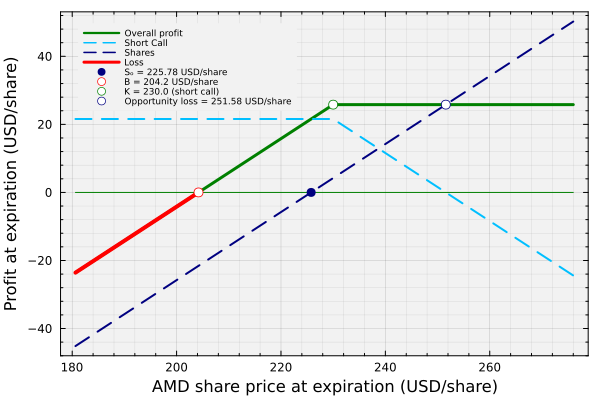

In [16]:
let
    # initialize 
    N = length(profit_array[:,1]); # how many steps do we have?
    BEL = zeros(N);
    K = call_contract_model.K;
    Sₚ = my_equity_model.purchase_price

    # SPL_vertical = range(-100,stop=100,length=N) |> collect;
    SPL_horizontal = Sₒ*ones(N);
    STRIKE_horizontal = K;
    max_profit = (call_contract_model.premium)+(K-Sₚ);
    max_profit_intersection = K + call_contract_model.premium;
    B = Sₚ - call_contract_model.premium;

    # setup the coloring -
    profit_idx = findall(>(0), profit_array[:,end])
    alternative_loss_index = findall(x->x ≥ max_profit_intersection, profit_array[:,end]);
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    plot(profit_array[:,1],profit_array[:,end], lw=3, c=:green, label="Overall profit", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legendfontsize=6, legend=:topleft,
        xminorticks=5, yminorticks=5, minorgrid=true);
    plot!(profit_array[:,1], BEL, c=:green, lw=1, label="")
    plot!(profit_array[:,1],profit_array[:,2], lw=2, c=:deepskyblue1, label="Short Call", ls=:dash)
    plot!(profit_array[:,1],profit_array[:,3], lw=2, c=:navy, label="Shares", ls=:dash)
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
    scatter!([Sₚ], [0], ms=5, c=:navy, msc=:navy, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    scatter!([B], [0], ms=5, c=:white, msc=:red, ls=:dash, label="B = $(B) USD/share")
    scatter!([K],[max_profit], ms=5, label = "K = $(K) (short call)", msc=:green, c=:white)
    scatter!([max_profit_intersection],[max_profit], ms=5, label = "Opportunity loss = $(round(max_profit_intersection, digits=2)) USD/share", msc=:navy, c=:white)
    
    xlabel!("AMD share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit at expiration (USD/share)", fontsize=18)
end

___

## Task 3: Probability of Outcomes
In this task, let's compute the probability of observing exit scenarios for our covered call position on `AMD`. We'll consider three scenarios:

> __Scenarios:__
>
> * __Scenario 1: Downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B} - \epsilon) = F_{S}\left(B - \epsilon\right)$.
> * __Scenario 2: Maximum profit__. In this scenario, the share price at expiration $S_{T}$ exceeds the strike price $K$. The probability of this scenario occurring is given by $P(S_{T} > K) = 1 - F_{S}\left(K\right)$.
> * __Scenario 3: Upside opportunity loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _above_ the alternative opportunity point $O^{+}$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}>O^{+} + \epsilon) = 1 - F_{S}\left(O^{+} + \epsilon\right)$.

To start, let's build a model of the future underlying share price at expiration $S(T)$. Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 

> __Risk-neutral pricing__: We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data. This gives us the risk-neutral simulation of the underlying share price at expiration.

We'll save the model in the `model::MyGeometricBrownianMotionEquityModel` variable, and the implied volatility value in the `σ̄::Float64` variable.

In [17]:
model, σ̄ = let

    # Step 1: get the implied volatility 
    σ̄ = call_leg_data[:IV];

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate,
        σ = σ̄
    ));

    model, σ̄
end;

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

So what do we get?

In [18]:
endpoint = let
    number_of_samples = 25000; # TODO: adjust me!
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model emits a LogNormal share price distribution. Fit a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm::LogNormal` variable.

In [19]:
d_gbm = fit_mle(LogNormal, endpoint);

### Cumulative distribution
Next, estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the geometric Brownian motion share price distribution. 
We can query the cumulative distribution function $F_{S}(\star)$ for the projected geometric Brownian motion distribution `d_gbm` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

#### Visualize
`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for `AMD` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` model:

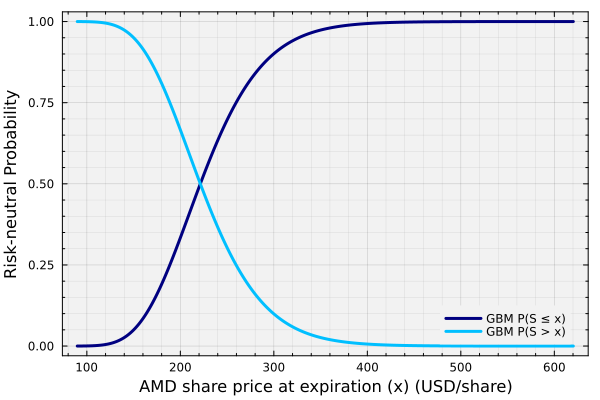

In [20]:
let
    number_of_samples = length(endpoint);
    X = Array{Float64,2}(undef, number_of_samples, 2);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint)
        push!(S,endpoint[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5, minorgrid=true,
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legendfontsize=8, legend=:bottomright)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)")

    xlabel!("AMD share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Risk-neutral Probability", fontsize=18);
end

Now that we have the cumulative distribution function for the geometric Brownian motion share price distribution, let's compute the probability of observing each of the three scenarios outlined above.

> __Scenario 1: Downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B} - \epsilon) = F_{S}\left(B - \epsilon\right)$.

Let's save the probability of this scenario occurring in the `p_downside_loss_gbm::Float64` variable.

In [21]:
p_downside_loss_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_downside_loss_gbm = nothing;

    # compute P(S < B_low -  ϵ) for the GBM model
    p_downside_loss_gbm = cdf(d_gbm,B-ϵ);

    # return data -
    p_downside_loss_gbm
end;

In [ ]:
println("Scenario 1: Probability of downside GBM = $(p_downside_loss_gbm)")

Scenario 1: Probability downside GBM = 0.3661739876697371


We've seen how to compute the probability of downside loss using the cumulative distribution function for the geometric Brownian motion share price distribution. Next, let's compute the probability of maximum profit.

> __Scenario 2: Maximum profit__. In this scenario, the share price at expiration $S({T})$ exceeds the strike price $K$ by at least `+0.01` USD/share. The probability of this scenario occurring is given by $P(S(T) > K + \epsilon) = 1 - F_{S}\left(K + \epsilon\right)$.

We'll save the probability of this scenario occurring in the `p_max_profit_gbm::Float64` variable.

In [23]:
p_max_profit_gbm = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    K = call_contract_model.K

    # compute the probability P(S > K) for the GBM
    p_max_profit_gbm = 1 - cdf(d_gbm,K+ϵ);

    # return data -
    p_max_profit_gbm
end;

In [24]:
println("Scenario 2: Probability max profit GBM = $(p_max_profit_gbm)")

Scenario 2: Probability max profit GBM = 0.43566929792089015


Would we be better off holding the shares instead of selling the covered call? Let's compute the probability of opportunity loss.

> __Scenario 3: Upside opportunity loss__. In this scenario, the share price at expiration $S(T)$ is at least $\epsilon$ _above_ the alternative opportunity point $O^{+}$, assuming $\epsilon \geq$ `0.01` USD/share. The probability of this scenario occurring is given by $P(S(T) >O^{+} + \epsilon) = 1 - F_{S}\left(O^{+} + \epsilon\right)$.

We'll save the probability of this scenario occurring in the `p_opportunity_loss_gbm::Float64` variable.

In [25]:
p_upside_opp_loss = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_upside_opp_loss = nothing;
    K = call_contract_model.K
    OP = K + call_contract_model.premium;

    # compute the probability P(S > O + e) for the GBM
    p_upside_opp_loss = 1 - cdf(d_gbm, OP + ϵ)

    # return data -
    p_upside_opp_loss
end;

In [26]:
println("Scenario 3: Probability of upside opportunity loss GBM = $(p_upside_opp_loss)")

Scenario 3: Probability of upside opportunity loss GBM = 0.2940768462037825


Let's summarize our probability results in a table.

In [27]:
let

    # initialize -
    df = DataFrame();

    # populate the data frame -
    row_df = (
        ticker = ticker,
        Sₒ = Sₒ,
        DTE = DTE,
        strike_price_K = call_contract_model.K,
        premium = call_contract_model.premium,
        max_profit = max_profit,
        breakeven_B = B,
        σ̄ = σ̄,
        p_downside_loss_gbm = p_downside_loss_gbm,
        p_max_profit_gbm = p_max_profit_gbm,
        p_upside_opp_loss = p_upside_opp_loss
    );
    push!(df, row_df); # store the row

    # make a table -
    pretty_table(
         df;
         fit_table_in_display_horizontally = false,
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- --------- --------- ---------------- --------- ------------ ------------- --------- --------------------- ------------------ -------------------
  ticker        Sₒ       DTE   strike_price_K   premium   max_profit   breakeven_B         σ̄   p_downside_loss_gbm   p_max_profit_gbm   p_upside_opp_loss 
  String   Float64   Float64          Float64   Float64      Float64       Float64   Float64               Float64            Float64             Float64 
 -------- --------- --------- ---------------- --------- ------------ ------------- --------- --------------------- ------------------ -------------------
     amd    225.78      58.0            230.0     21.58         25.8         204.2    0.5912              0.366174           0.435669            0.294077
 -------- --------- --------- ---------------- --------- ------------ ------------- --------- --------------------- ------------------ -------------------


___

## Summary
This example demonstrates how to construct and analyze a covered call position using options data and projected share price distributions.

> __Key Takeaways:__
>
> * __Covered calls have limited upside and downside protection:__ The maximum profit is capped at the strike price plus premium minus the share acquisition cost, while the breakeven point is the share acquisition price minus the premium received. Losses occur when the share price falls below the breakeven point.
> * __Probability analysis identifies trade-off scenarios:__ The likelihood of downside loss, maximum profit, and opportunity loss can be calculated using the cumulative distribution function of projected share prices, enabling traders to quantify the risk-reward profile before entering the position.
> * __Opportunity risk limits potential gains:__ When the share price rises above the strike price, the call is exercised and shares are sold at the strike, capping profit. The probability of missing gains above this level represents the opportunity cost of selling the covered call versus holding shares alone.

Understanding covered call positions enables traders to generate income from equity holdings while accepting limited upside potential.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.